In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/Raza/miniconda3/envs/default/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from utils.func_utils import accept, jacobian, autocovariance, get_log_likelihood, \
    get_data, binarize, normal_kl, acl_spectrum, ESS
from utils.distributions import Gaussian, GMM, GaussianFunnel, gen_ring
from utils.layers import Linear, Sequential, Zip, Parallel, ScaleTanh
from utils.dynamics import Dynamics
from utils.sampler import propose
from utils.notebook_utils import get_hmc_samples

## Network architecture

We define the network architecture for our L2HMC network. We first embed the first two variables ($\{x, \partial_x U\}$ or $\{v, x_m\}$) as well as the time, formatted as $\tau(t) = \left(\cos(\frac{2\pi t}{M}), \sin(\frac{2\pi t}{M})\right)$. They are forwarded through an MLP and then produce $S, T$ and $Q$.

In [3]:
def network(x_dim, scope, factor):
    with tf.variable_scope(scope):
        net = Sequential([
            Zip([
                Linear(x_dim, 10, scope='embed_1', factor=1.0 / 3),
                Linear(x_dim, 10, scope='embed_2', factor=factor * 1.0 / 3),
                Linear(2, 10, scope='embed_3', factor=1.0 / 3),
                lambda _: 0.,
            ]),
            sum,
            tf.nn.relu,
            Linear(10, 10, scope='linear_1'),
            tf.nn.relu,
            Parallel([
                Sequential([
                    Linear(10, x_dim, scope='linear_s', factor=0.001), 
                    ScaleTanh(x_dim, scope='scale_s')
                ]),
                Linear(10, x_dim, scope='linear_t', factor=0.001),
                Sequential([
                    Linear(10, x_dim, scope='linear_f', factor=0.001),
                    ScaleTanh(x_dim, scope='scale_f'),
                ])
            ])  
        ])
        
    return net

In [6]:
parameters = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
num_p = 0
for p in parameters:
    acc = 1
    for d in range(len(p.shape)):
        acc *= int(p.shape[d])
    num_p += acc
print('num paramters = {}'.format(num_p))

num paramters = 541


## Distribution

We define our energy function. It is a Mixture of Guassian Distribution with means at (10, 0) and (-10, 0)

In [5]:
x_dim = 2
means = [np.array([10., 0.0]).astype(np.float32), np.array([-10.0, 0.0]).astype(np.float32)] 
covs = [np.array([[1.0, 0.0],[0.0, 1.0]]), np.array([[1.0, 0.0],[0.0, 1.0]])]
distribution = GMM(means, covs, [0.5, 0.5])

dynamics = Dynamics(x_dim, distribution.get_energy_function(), T=10, eps=0.1, net_factory=network)

We can directly sample from this distribution and plot it for sanity-check.

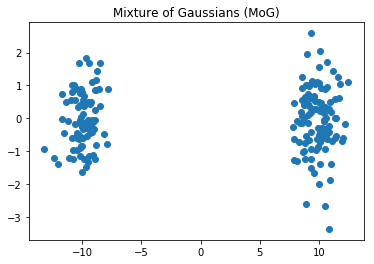

In [9]:
S = distribution.get_samples(200)
plt.title('Mixture of Gaussians (MoG)')
plt.scatter(S[:, 0], S[:, 1])
plt.show()

We set up the loss on both $p(\xi)$ (here `x`) and $q(\xi)$ (here `z`). We then train with Adam with a learning rate of $10^{-3}$.

In [10]:
x = tf.placeholder(tf.float32, shape=(None, x_dim))
z = tf.random_normal(tf.shape(x))

Lx, _, px, output = propose(x, dynamics, do_mh_step=True)
Lz, _, pz, _ = propose(z, dynamics, do_mh_step=False)

loss = 0.

v1 = (tf.reduce_sum(tf.square(x - Lx), axis=1) * px) + 1e-4
v2 = (tf.reduce_sum(tf.square(z - Lz), axis=1) * pz) + 1e-4
scale = 1

loss += scale * (tf.reduce_mean(1.0 / v1) + tf.reduce_mean(1.0 / v2))
loss += (- tf.reduce_mean(v1) - tf.reduce_mean(v2)) / scale

In [11]:
global_step = tf.Variable(0., name='global_step', trainable=False)
learning_rate = tf.train.exponential_decay(1e-3, global_step, 1000, 0.96, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss, global_step=global_step)

The training loop described in Algorithm $1$.

In [ ]:
import time
time1 = time.time
n_steps = 5000
n_samples = 200
losses = []

samples = np.random.randn(n_samples, x_dim)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for t in range(n_steps):
    _, loss_, samples, px_, lr_ = sess.run([
        train_op,
        loss,
        output[0],
        px,
        learning_rate,
    ], {x: samples})
    losses.append(loss_)
    

    if t % 100 == 0:
        print('Step: %d / %d, Loss: %.2e, Acceptance sample: %.2f, LR: %.5f' % (t, n_steps, loss_, np.mean(px_), lr_))
time2 = time.time
print('Time to train sampler was {} seconds'.format(time2 - time1))

Step: 0 / 5000, Loss: 3.48e+01, Acceptance sample: 0.53, LR: 0.00100
Step: 100 / 5000, Loss: -2.42e+00, Acceptance sample: 0.64, LR: 0.00100
Step: 200 / 5000, Loss: -4.20e+01, Acceptance sample: 0.72, LR: 0.00100
Step: 300 / 5000, Loss: -1.05e+02, Acceptance sample: 0.56, LR: 0.00100
Step: 400 / 5000, Loss: -1.77e+02, Acceptance sample: 0.49, LR: 0.00100
Step: 500 / 5000, Loss: -2.34e+02, Acceptance sample: 0.60, LR: 0.00100
Step: 600 / 5000, Loss: -2.42e+02, Acceptance sample: 0.70, LR: 0.00100
Step: 700 / 5000, Loss: -2.97e+02, Acceptance sample: 0.71, LR: 0.00100
Step: 800 / 5000, Loss: -3.16e+02, Acceptance sample: 0.68, LR: 0.00100
Step: 900 / 5000, Loss: -3.21e+02, Acceptance sample: 0.66, LR: 0.00100
Step: 1000 / 5000, Loss: -3.36e+02, Acceptance sample: 0.79, LR: 0.00096
Step: 1100 / 5000, Loss: -3.25e+02, Acceptance sample: 0.71, LR: 0.00096
Step: 1200 / 5000, Loss: -3.32e+02, Acceptance sample: 0.76, LR: 0.00096
Step: 1300 / 5000, Loss: -3.15e+02, Acceptance sample: 0.64, LR:

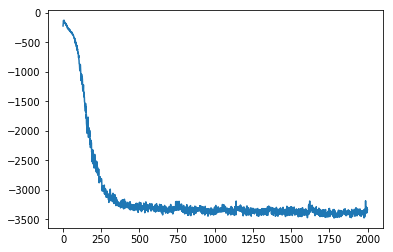

In [9]:
plt.plot(losses)

After training, we generate $200$ chains for $2000$ steps for evaluation purposes.

In [10]:
samples = distribution.get_samples(n=n_samples)
final_samples = []

for t in range(2000):
    final_samples.append(np.copy(samples))

    feed_dict = {
        x: samples,
    }

    samples = sess.run(output[0], feed_dict)

We compute the HMC chains with **auto-correlation spectrums** as well.

In [12]:
L2HMC_samples = np.array(final_samples)
# HMC_samples_1 = get_hmc_samples(2, 0.1, distribution.get_energy_function(), sess, steps=2000, samples=samples)
# HMC_samples_2 = get_hmc_samples(2, 0.15, distribution.get_energy_function(), sess, steps=2000, samples=samples)
# HMC_samples_3 = get_hmc_samples(2, 0.2, distribution.get_energy_function(), sess, steps=2000, samples=samples)

In [13]:
# scale = np.sqrt(np.trace(cov))
# L2HMC = acl_spectrum(L2HMC_samples, scale=scale)
# HMC1 = acl_spectrum(HMC_samples_1, scale=scale)
# HMC2 = acl_spectrum(HMC_samples_2, scale=scale)
# HMC3 = acl_spectrum(HMC_samples_3, scale=scale)

NameError: name 'cov' is not defined

We can plot auto-correlation.

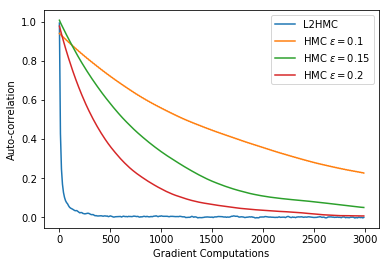

In [30]:
xaxis = 10 * np.arange(300)
plt.plot(xaxis, L2HMC[:300], label='L2HMC')
plt.plot(xaxis, HMC1[:300], label='HMC $\epsilon=0.1$')
plt.plot(xaxis, HMC2[:300], label='HMC $\epsilon=0.15$')
plt.plot(xaxis, HMC3[:300], label='HMC $\epsilon=0.2$')
plt.ylabel('Auto-correlation')
plt.xlabel('Gradient Computations')
plt.legend()
plt.show()

We now compute the **Effective Sample Size** (ESS).

In [25]:
print 'ESS L2HMC: %.2e -- ESS HMC: %.2e -- Ratio: %d' % (ESS(L2HMC), ESS(HMC2), ESS(L2HMC) / ESS(HMC2))

ESS L2HMC: 2.61e-01 -- ESS HMC: 5.63e-03 -- Ratio: 46


We can visualize a single chain of L2HMC for $50$ time steps.

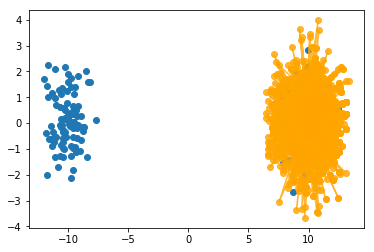

In [14]:
plt.scatter(S[:, 0], S[:, 1])
plt.plot(L2HMC_samples[:, 5, 0], L2HMC_samples[:, 5, 1], color='orange', marker='o', alpha=0.8)
plt.show()